In [167]:
import unicodedata
import string
import re
import time
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import pickle

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torch.optim import lr_scheduler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 导入数据

- 导入数据
- 并将数据保存为pkl的格式

In [2]:
def convert_to_pickle(item, directory):
    """导出数据
    """
    pickle.dump(item, open(directory,"wb"))


def load_from_pickle(directory):
    """导入数据
    """
    return pickle.load(open(directory,"rb"))

## 数据的预处理

数据预处理大致分为下面几个部分.

1. 将所有字母转为Ascii
2. 将大写都转换为小写; 同时, 只保留常用的标点符号
3. 新建完成, word2idx, idx2word, word2count(每个单词出现的次数), n_word(总的单词个数)
4. 将句子转换为Tensor, 每个word使用index来进行代替
5. 对句子进行填充, 使每句句子的长度相同, 这样可以使用batch进行训练
6. 将label转换为one-hot的格式, 方便最后的训练(Pytorch中只需要转换为标号即可)

### 创建word2index和index2word

In [287]:
# 第一步数据预处理
def unicodeToAscii(s):
    """转换为Ascii
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 第二步数据预处理
def normalizeString(s):
    """转换为小写, 同时去掉奇怪的符号
    """
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# 第三步数据预处理
class Lang():
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        # 初始的时候SOS表示句子开头(0还在padding的时候会进行填充), EOS表示句子结尾(或是表示没有加入index中的新的单词, 即不常用的单词)
        self.index2word = {0:"SOS",1:"EOS"}
        self.n_words = 2
    
    def addSentence(self, sentence):
        """把句子中的每个单词加入字典中
        """
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words # 新单词的标号
            self.word2count[word] = 1 # 新单词的个数
            self.index2word[self.n_words] = word
            self.n_words = self.n_words + 1
        else:
            self.word2count[word] = self.word2count[word] + 1

In [288]:
lang = Lang()

with open('./medium_text.txt', 'r', encoding="utf-8") as file:
    for line in file:
        # 每次读取文件的一行
        text = file.readline()
        # 接着将这一行的单词生成word2index
        sentence_data = normalizeString(text)
        lang.addSentence(sentence_data)

# 显示一些统计数据
print("Count word:{}".format(lang.n_words))

Count word:1110


In [10]:
# 打印一下单词个数的分布
data_count = np.array(list(lang.word2count.values()))

# 有大量单词只出现了很少的次数
np.median(data_count), np.mean(data_count), np.max(data_count) 

(1.0, 4.61913357400722, 328)

In [232]:
# 计算<n的单词, 单词的个数和总的单词个数
less_count = 0
total_count = 0

for _,count in lang.word2count.items():
    if count < 2:
        less_count = less_count + 1
    total_count = total_count + 1

print("小于N的单词出现次数 : ",less_count,
      "\n总的单词出现次数 : ",total_count, 
      "\n小于N的单词占总的单词个数比例 : ",less_count/total_count*100)

小于N的单词出现次数 :  634 
总的单词出现次数 :  1105 
小于N的单词占总的单词个数比例 :  57.375565610859724


In [233]:
# 计算<n的单词, 出现次数占总的出现次数的比例
less_count = 0
total_count = 0

for _,count in lang.word2count.items():
    if count < 2:
        less_count = less_count + count
    total_count = total_count + count

print("小于N的单词出现次数 : ",less_count,
      "\n总的单词出现次数 : ",total_count, 
      "\n小于N的单词占单词个数比例 : ",less_count/total_count*100)

小于N的单词出现次数 :  634 
总的单词出现次数 :  4472 
小于N的单词占单词个数比例 :  14.177101967799643


In [289]:
# 我们设置单词至少出现2次(我们还是保留这些单词吧)
lang_process = Lang()

for word,count in lang.word2count.items():
    if count >= 1:
        lang_process.word2index[word] = lang_process.n_words # 新单词的标号
        lang_process.word2count[word] = count # 新单词的个数
        lang_process.index2word[lang_process.n_words] = word
        lang_process.n_words = lang_process.n_words + 1
        
# 显示一些统计数据
print("Count word:{}".format(lang_process.n_words))

Count word:1110


In [15]:
# 简单查看一下lang_process留下的单词
lang_process.word2count

{'the': 241,
 'last': 13,
 'question': 11,
 'was': 56,
 'asked': 12,
 'for': 40,
 'first': 6,
 'time': 12,
 'half': 5,
 'in': 60,
 'jest': 1,
 'on': 27,
 'may': 6,
 'at': 20,
 'a': 103,
 'when': 14,
 'humanity': 2,
 'stepped': 1,
 'into': 13,
 'light': 4,
 '.': 328,
 'came': 5,
 'about': 11,
 'as': 24,
 'result': 1,
 'of': 133,
 'five': 4,
 'dollar': 1,
 'bet': 2,
 'over': 6,
 'highballs': 1,
 'and': 120,
 'it': 77,
 'happened': 1,
 'this': 13,
 'way': 6,
 '': 193,
 'alexander': 1,
 'adell': 10,
 'bertram': 1,
 'lupov': 10,
 'were': 13,
 'two': 10,
 'faithful': 1,
 'attendants': 1,
 'multivac': 15,
 'well': 3,
 'any': 8,
 'human': 4,
 'beings': 2,
 'could': 12,
 'they': 19,
 'knew': 4,
 'what': 14,
 'lay': 1,
 'behind': 2,
 'cold': 1,
 'clicking': 2,
 'flashing': 2,
 'face': 4,
 'miles': 3,
 'that': 50,
 'giant': 3,
 'computer': 4,
 'had': 46,
 'least': 2,
 'vague': 2,
 'notion': 1,
 'general': 1,
 'plan': 1,
 'relays': 2,
 'circuits': 1,
 'long': 5,
 'since': 3,
 'grown': 1,
 'past': 

In [17]:
convert_to_pickle(lang_process, './data/lang_process.pkl')

## 构建数据集

- 构建数据集样式 ([ word_i-1, word_i_1 ], word_i(target word))
- 将word转为tensor
- 将数据集构建为batch的样式

In [290]:
# 对每句话构建数据集
train_data = []
target_data = []

with open('./medium_text.txt', 'r', encoding="utf-8") as file:
    for line in file:
        # 每次读取文件的一行
        text = file.readline()
        # 接着将这一行的单词生成word2index
        sentence_datas = normalizeString(text)
        # 将每一行数据做处理
        sentence_datas_list = sentence_datas.split(' ')
        # sentence_datas_list = [i for i in sentence_datas_list if i not in ['the','it','.', 'of', 'a']]
        for i in range(1, len(sentence_datas_list)-1):
            b = np.array([sentence_datas_list[i-1], sentence_datas_list[i+1]])
            target_data.append(b)
            train_data.append(sentence_datas_list[i])
            # train_data = np.vstack((train_data, b))
            # target_data = np.concatenate((target_data, [sentence_datas_list[i]]))
train_data = np.array(train_data)
target_data = np.array(target_data)

In [291]:
# 将word转为tensor
# 转换为tensor
train_tensor = torch.tensor([lang_process.word2index[w] for w in train_data], dtype=torch.long)

target_tensor = torch.zeros(target_data.shape, dtype=torch.long)

for num ,t_d in enumerate(target_data):
    add_num = torch.tensor([lang_process.word2index[ws] for ws in t_d], dtype=torch.long)
    target_tensor[num : num+1] = add_num

In [292]:
train_data[25:30]

array(['question', 'came', 'about', 'as', 'a'], dtype='<U17')

In [293]:
train_tensor[25:30]

tensor([ 4, 23, 24, 25, 16])

In [294]:
lang_process.index2word[4],lang.index2word[23],lang.index2word[24],lang.index2word[25]

('question', 'came', 'about', 'as')

In [295]:
target_data[25:30]

array([['the', 'came'],
       ['question', 'about'],
       ['came', 'as'],
       ['about', 'a'],
       ['as', 'result']], dtype='<U17')

In [296]:
target_tensor[25:30]

tensor([[ 2, 23],
        [ 4, 24],
        [23, 25],
        [24, 16],
        [25, 26]])

## 构建Word2Vector网络-使用Skip-gram算法

- 构建model

In [297]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size*context_size)
    
    def forward(self, x):
        # x的大小为, (batch_size, context_size=1, word_index)
        # embedding(x)的大小为, (batch_size, context_size=1, embedding_dim)
        # embeds的大小为, (batch_size, context_size*embedding_dim)
        batch_size = x.size(0)
        embeds = self.embeddings(x).squeeze(1)
        output = F.relu(self.linear1(embeds)) # batch_size*128
        output = F.log_softmax(self.linear2(output),dim=1).view(batch_size, self.vocab_size, self.context_size) # batch * vocab_size*context_size
        output = output.permute(0,2,1)# batch * context_size * vocab_size
        return output

In [149]:
# 网络的测试
skipgram = SkipGram(lang_process.n_words, embedding_dim=30, context_size=2)

# 网络的输入
output = skipgram(train_tensor[:3].view(-1,1))
# batch_size*vocab_size*context_size
output.shape

torch.Size([3, 2, 1110])

## Data Loader

- 数据集的划分, 训练集和测试集
- 数据集的加载, 使用DataLoader来加载数据集

In [298]:
# 加载dataloader
train_dataset = Data.TensorDataset(train_tensor.view(-1,1), target_tensor) # 训练样本

MINIBATCH_SIZE = 64

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=1      # set multi-work num read data
)

In [145]:
for num, (i,j) in enumerate(train_loader):
    print(num, i.shape, j.shape)
    break

0 torch.Size([64, 1]) torch.Size([64, 2])


到这里，就创建好了dataload, 后面就可以开始构建网络，可以开始训练了

## 训练模型
- 定义损失函数
- 定义优化器

- 开始训练

In [304]:
# 模型超参数
NUM_EPOCH = 100
losses = []
loss_function = nn.NLLLoss()
model = SkipGram(lang_process.n_words, embedding_dim=30, context_size=2)
optimizer = optim.Adam(model.parameters(), lr=0.05)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# 模型开始训练
for epoch in range(NUM_EPOCH):
    total_loss = 0
    exp_lr_scheduler.step()
    for num, (trainData, targetData) in enumerate(train_loader):
        # 正向传播
        log_probs = model(trainData)
        # 两次loss分开加
        loss = loss_function(log_probs[:,0,:], targetData[:,0])
        loss = loss + loss_function(log_probs[:,1,:], targetData[:,1])
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
    if (epoch+1) % 5 == 0:
        print('Epoch : {:0>3d}, Loss : {:<6.4f}, Lr : {:<6.7f}'.format(epoch, total_loss, optimizer.param_groups[0]['lr']))

Epoch : 004, Loss : 867.0024, Lr : 0.0500000
Epoch : 009, Loss : 852.2501, Lr : 0.0500000
Epoch : 014, Loss : 764.0075, Lr : 0.0250000
Epoch : 019, Loss : 751.6975, Lr : 0.0250000
Epoch : 024, Loss : 722.9565, Lr : 0.0125000
Epoch : 029, Loss : 720.6759, Lr : 0.0125000
Epoch : 034, Loss : 708.5292, Lr : 0.0062500
Epoch : 039, Loss : 705.4716, Lr : 0.0062500
Epoch : 044, Loss : 699.4564, Lr : 0.0031250
Epoch : 049, Loss : 697.2512, Lr : 0.0031250
Epoch : 054, Loss : 694.4325, Lr : 0.0015625
Epoch : 059, Loss : 692.7617, Lr : 0.0015625
Epoch : 064, Loss : 692.8118, Lr : 0.0007813
Epoch : 069, Loss : 690.0575, Lr : 0.0007813
Epoch : 074, Loss : 690.8663, Lr : 0.0003906
Epoch : 079, Loss : 689.9322, Lr : 0.0003906
Epoch : 084, Loss : 688.1442, Lr : 0.0001953
Epoch : 089, Loss : 688.5302, Lr : 0.0001953
Epoch : 094, Loss : 688.5862, Lr : 0.0000977
Epoch : 099, Loss : 685.8867, Lr : 0.0000977


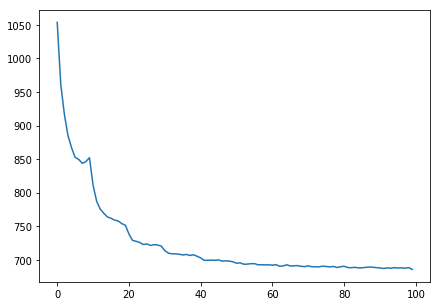

In [305]:
# 打印出loss的变化情况
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)

ax.plot(losses)

In [181]:
# 保存模型
torch.save(model, 'Word2Vec.pkl')

In [208]:
train_tensor[:3].view(-1,1).shape

torch.Size([3, 1])

In [221]:
train_data[1:14]

array(['question', 'was', 'asked', 'for', 'the', 'first', 'time', 'half',
       'in', 'jest', 'on', 'may', 'at'], dtype='<U17')

In [222]:
target_data[1:14]

array([['last', 'was'],
       ['question', 'asked'],
       ['was', 'for'],
       ['asked', 'the'],
       ['for', 'first'],
       ['the', 'time'],
       ['first', 'half'],
       ['time', 'in'],
       ['half', 'jest'],
       ['in', 'on'],
       ['jest', 'may'],
       ['on', 'at'],
       ['may', 'a']], dtype='<U17')

In [306]:
# 查看一下使用模型预测的准确率
test_output = model(train_tensor[1:14].view(-1,1))
before_word = test_output[:,0,:]
after_word = test_output[:,1,:]
print(torch.max(before_word,1)[1])
print('=========')
print(torch.max(after_word,1)[1])

tensor([ 27,  34,  89, 483,  27,  22,  16,   9,  22,  11,  22, 457, 117])
tensor([ 22,  40,  16,   2, 396,   2, 297,   2,   2,  13,   2,  90,   2])


In [307]:
target_tensor[1:14]

tensor([[ 3,  5],
        [ 4,  6],
        [ 5,  7],
        [ 6,  2],
        [ 7,  8],
        [ 2,  9],
        [ 8, 10],
        [ 9, 11],
        [10, 12],
        [11, 13],
        [12, 14],
        [13, 15],
        [14, 16]])

In [313]:
lang_process.index2word[11]

'in'

## 使用t-SNE降维, 进行可视化

- 获取word2vector的值, 即nn.Embedding的weight
- 使用t-SNE进行降维, 降到2维, 方便之后的可视化(t-SNE是可以在没有label的情况下进行计算)
- 画出可视化的结果

In [199]:
model.embeddings(torch.tensor([1]))

tensor([[-2.0945, -0.3866, -0.4567,  0.3382, -0.0946,  1.1195, -0.6650,  1.2500,
         -0.7408, -0.4968,  0.3027, -0.9798, -1.5424, -0.0258, -2.5648,  0.3893,
          0.0741,  1.0028, -0.3342, -0.1573, -0.0044,  0.6600,  0.3217, -0.5805,
         -0.9723, -0.5392, -0.4659,  0.3165,  0.2696, -1.1011]],
       grad_fn=<EmbeddingBackward>)

In [200]:
model.embeddings.weight.data[1]

tensor([-2.0945, -0.3866, -0.4567,  0.3382, -0.0946,  1.1195, -0.6650,  1.2500,
        -0.7408, -0.4968,  0.3027, -0.9798, -1.5424, -0.0258, -2.5648,  0.3893,
         0.0741,  1.0028, -0.3342, -0.1573, -0.0044,  0.6600,  0.3217, -0.5805,
        -0.9723, -0.5392, -0.4659,  0.3165,  0.2696, -1.1011])

In [314]:
EMBEDDINGS = model.embeddings.weight.data
# 一共1110个单词, 每个单词使用长度为30的向量进行表示
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

EMBEDDINGS.shape:  torch.Size([1110, 30])


In [183]:
from sklearn.manifold import TSNE

In [315]:
print('running TSNE...')
tsne = TSNE(n_components = 2).fit_transform(EMBEDDINGS)
print('tsne.shape: ', tsne.shape) #(1110, 2)

running TSNE...
tsne.shape:  (1110, 2)


In [316]:
# 保存每个词汇的横轴坐标
x, y = [], []
annotations = []
for idx, coord in enumerate(tsne):
    # print(coord)
    annotations.append(lang_process.index2word[idx])
    x.append(coord[0])
    y.append(coord[1])

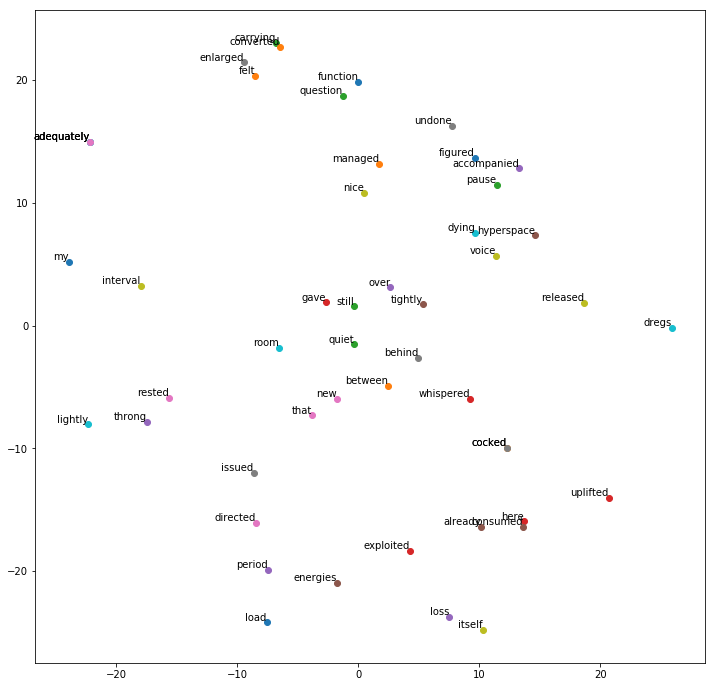

In [317]:
# 随便画20个点, 看一下哪些点是接近的
plt.figure(figsize = (12, 12))
for i in range(50):
    vocab_idx = random.randint(1,1110)
    word = annotations[vocab_idx]
    plt.scatter(x[vocab_idx], y[vocab_idx])
    plt.annotate(word, xy = (x[vocab_idx], y[vocab_idx]), ha='right',va='bottom')

plt.show()